In [63]:
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk, ImageOps
import cv2
import time
import os

In [64]:
def my_imshow(img,scale=0.3, time_show = 5):
    image = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
    cv2.imshow("hehe",image)
    cv2.waitKey(time_show*1000)
    cv2.destroyAllWindows()

def get_listen_test_image(image):
    height, width, channels = image.shape
    padding = 0.00886739218057235 * width
    per_width = [0.12615880693268844, 0.5030229746070133]
    per_height = (0.153363740022805, 0.47063854047890535)
    return image[int(per_height[0]*height):int(per_height[1]*height),\
                 int(per_width[0]*width+padding):int(per_width[1]*width-padding)]
def get_reading_test_image(image):
    height, width, channels = image.shape
    padding_left = 0.012494961708988311 * width
    padding_right = 0.004433696090286175 * width
    per_width = [0.5171301894397421, 0.8935912938331319]
    per_height = (0.153363740022805, 0.47063854047890535)
    return image[int(per_height[0]*height):int(per_height[1]*height),\
                 int(per_width[0]*width+padding_left):int(per_width[1]*width-padding_right)]
def get_columns(image, n_col = 4):
    lst = []
    padding = int(0.008464328899637243*width) # width = 2481
    w = int(round(image.shape[1]/4))
    for i in range(n_col):
        sheet = image[:,w*i:w*(i+1)]
        img = sheet[:, padding:(sheet.shape[1]-padding)]
        lst.append(img)
    return lst
def get_my_ans(image_ans, ANSWER_KEY, draw_img, index_sheet = 0, type_test = "listening", thresh_value = 150, limit_value = 240):
    translate = {"A": 0, "B": 1, "C": 2, "D": 3}
    revert_translate = {0: "A", 1: "B", 2: "C", 3: "D", -1: "N"}
    img = image_ans.copy()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Xoá viền
    kernel = np.ones((5,5))
    imgDilation = cv2.dilate(blur, kernel, iterations = 2)
    # Phóng to phần tô màu
    erosion = cv2.erode(imgDilation, kernel, iterations = 2)
    # Chuyển thành giá trị nhị phân, giá trị nào dưới 100 về 0, ngược lại 255 (đen và trắng)
    _, thresh = cv2.threshold(erosion, thresh_value, 255, cv2.THRESH_BINARY)
    
    ans_char = ['A','B','C','D']
    my_answers = []
    
    height_each_ans = int(round(img.shape[0]/25))
    width_each_ans = int(round(img.shape[1]/4))
    
    n_questions = 25
    for i in range(n_questions):
        # Từng câu
        row_1_ans = thresh[height_each_ans*i:height_each_ans*(i+1), : ]
        min_mean = float('inf')
        selected_ans = None
        
        for j in range(4):
            mean_value = np.mean(row_1_ans[:, width_each_ans*j : width_each_ans*(j+1)])
            if mean_value < limit_value and mean_value < min_mean:
                min_mean = mean_value
                selected_ans = ans_char[j]
        if selected_ans is not None:
            my_answers.append(selected_ans)
        else:
            my_answers.append("-")
    
    r = 17
    start_h = 538
    padding = 42.25
    if type_test == "listening":
        
        start_w = int(357 + index_sheet*image_ans.shape[1] + padding*index_sheet)
    else: #reading
        start_w = int(1283+52.25+ index_sheet*image_ans.shape[1] + padding*index_sheet)
    
    for quest in range(n_questions):
        I_y = int(round(start_h + height_each_ans*(quest*0.99+0.5)))
        
        x_each_quest = (image_ans.shape[1]/4)
        
        I_x_key = start_w + int(x_each_quest*translate[ANSWER_KEY[quest]])+(image_ans.shape[1]/4)//2

        if my_answers[quest] == '-':
            cv2.circle(draw_img, (int(I_x_key), int(I_y)), r, (255, 0, 0), 3)
            continue
        I_x_my_ans = start_w + int(x_each_quest*translate[my_answers[quest]])+(image_ans.shape[1]/4)//2
        if my_answers[quest] == ANSWER_KEY[quest]:
            cv2.circle(draw_img, (int(I_x_my_ans), int(I_y)), r, (0, 255, 0), 3)
        else: 
            cv2.circle(draw_img, (int(I_x_my_ans), int(I_y)), r, (0, 0, 255), 3)
            cv2.circle(draw_img, (int(I_x_key), int(I_y)), r, (255, 0, 0), 3)
    return np.array(my_answers)

# Scan picture img1 or img2

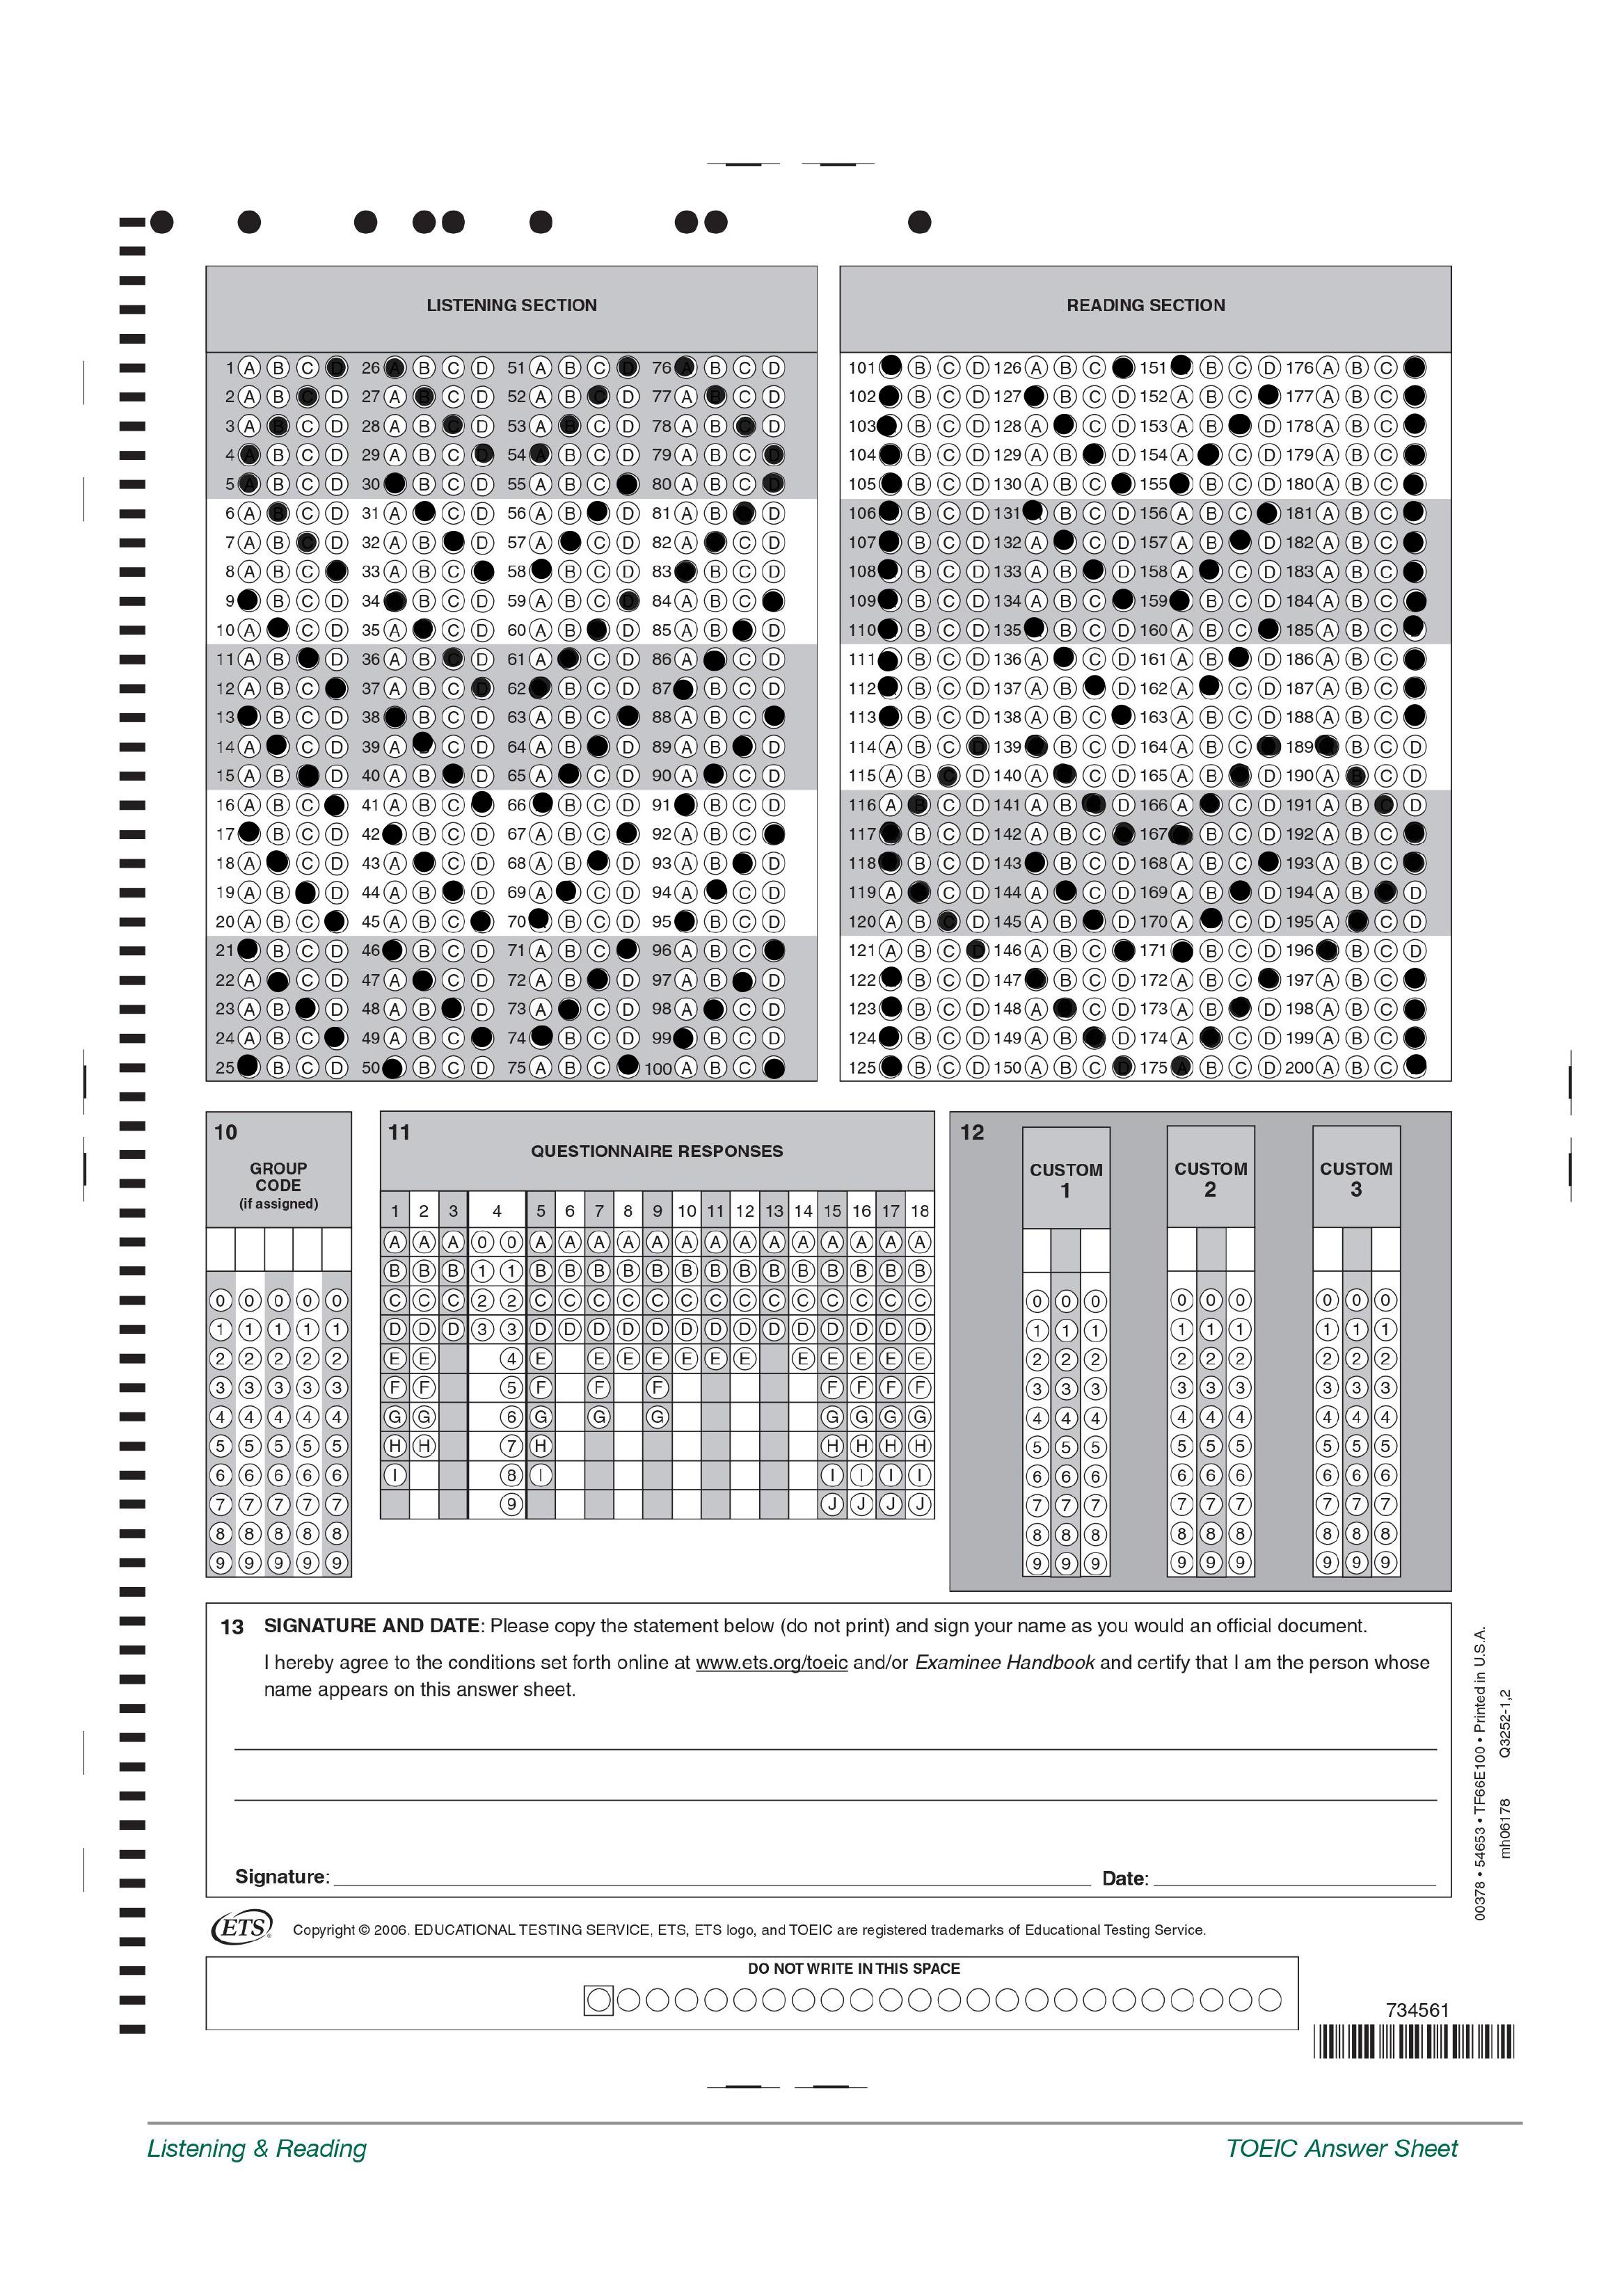


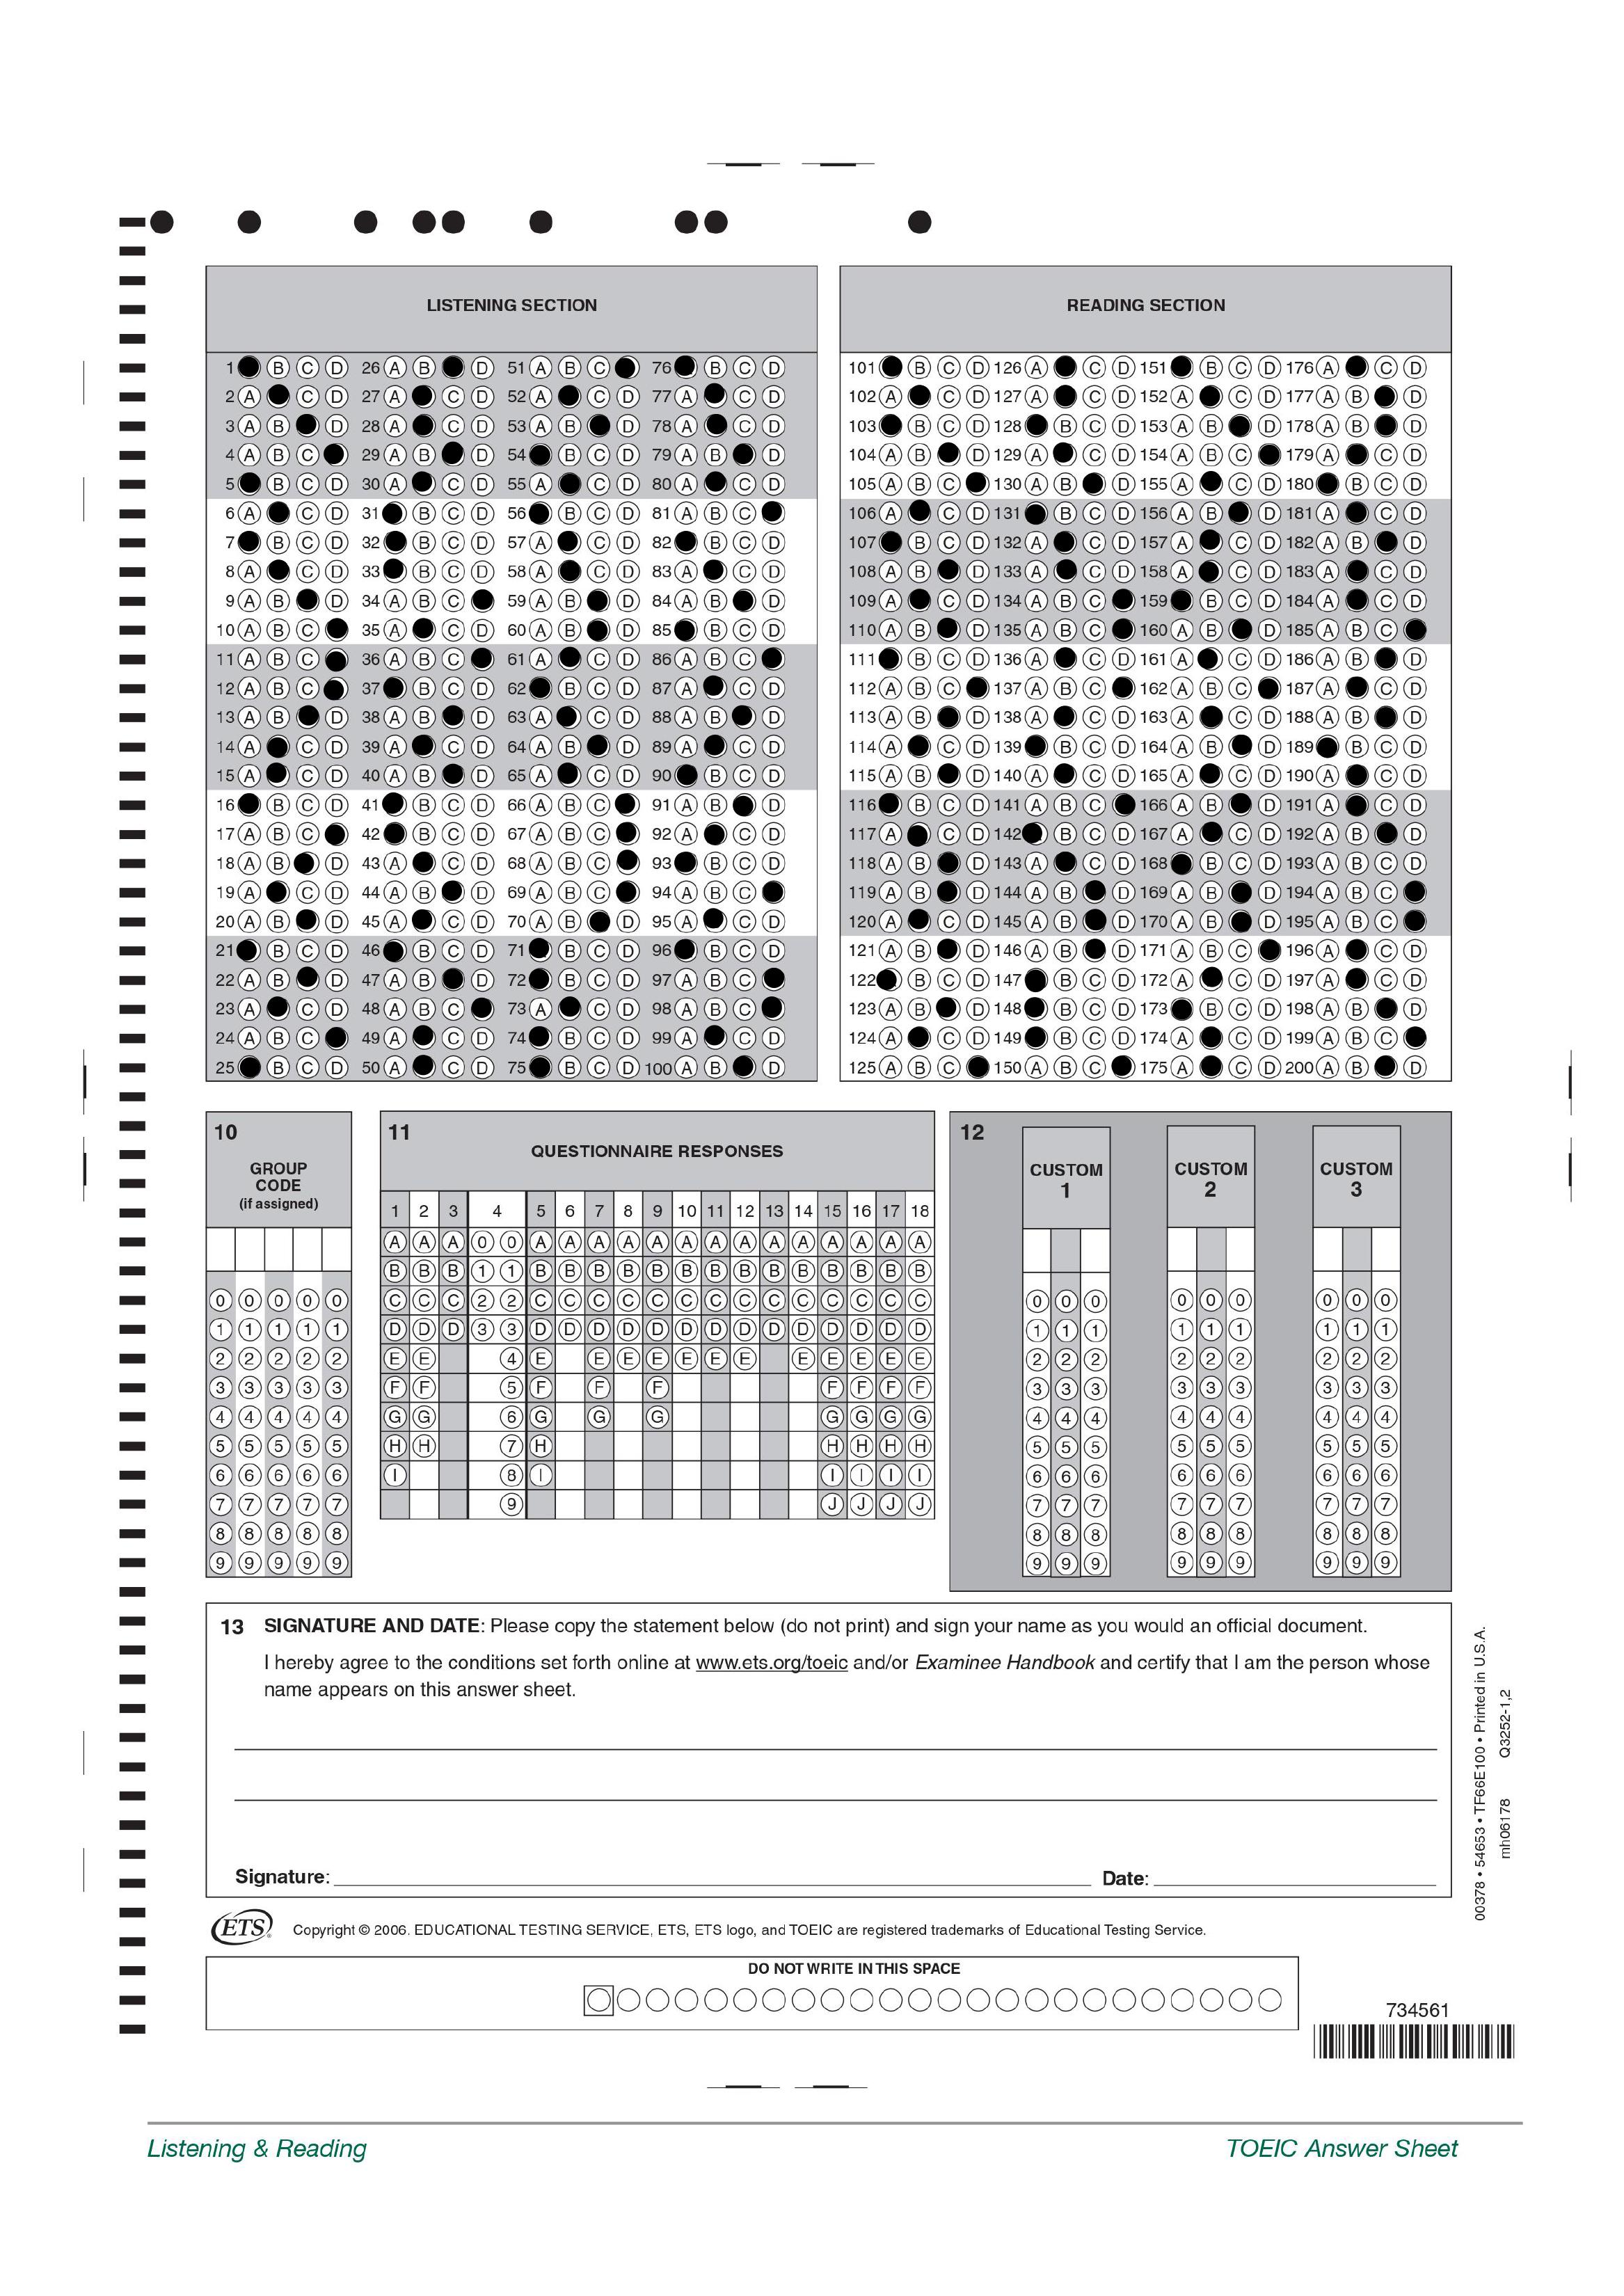

In [65]:
width, height = 2481, 3508
image = cv2.imread("img1.jpg")
# image = cv2.imread("img2.jpg")
image = cv2.resize(image, (width, height))
image.shape

(3508, 2481, 3)

In [66]:
img_lis = get_listen_test_image(image)
img_read = get_reading_test_image(image)

lst_img_lis = get_columns(img_lis)
lst_img_read = get_columns(img_read)


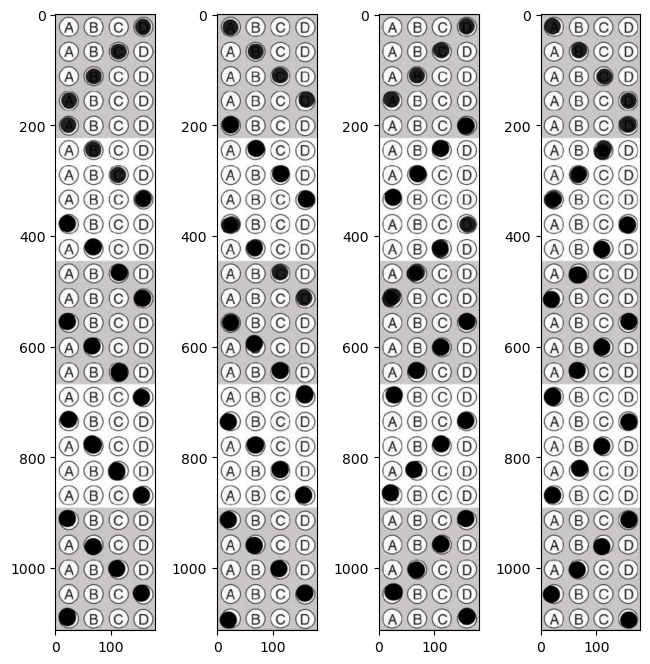

In [67]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(lst_img_lis[i])
plt.show()

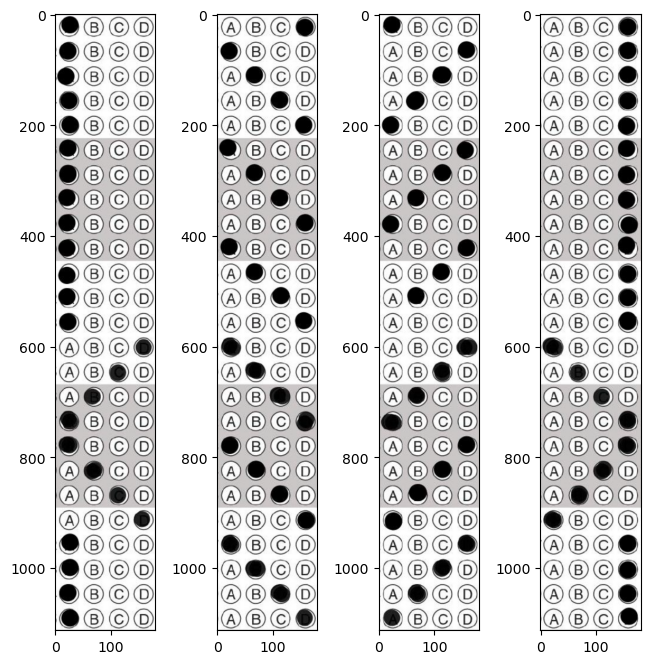

In [68]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(lst_img_read[i])
plt.show()

In [69]:
img_draw = image.copy()
ans_listening, ans_reading = [],[]

keys_listening = ['A']*100
keys_reading = ['B']*100

for i,sheet in enumerate(lst_img_lis):
    keys = keys_listening[25*i:25*(i+1)]
    ans = get_my_ans(sheet, keys, img_draw, i, 'listening')
    for x in ans:
        ans_listening.append(x)
    
for i,sheet in enumerate(lst_img_read):
    keys = keys_reading[25*i:25*(i+1)]
    ans = get_my_ans(sheet, keys , img_draw, i, 'reading')
    for x in ans:
        ans_reading.append(x)



In [70]:
score_listening, score_reading = 0,0
img_draw = img_draw.copy()
for i in range(100):
    if keys_listening[i]== ans_listening[i]:
        score_listening +=1
    if keys_reading[i]== ans_reading[i]:
        score_reading+=1
cv2.putText(img_draw, f"{score_listening}/100", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 5)
cv2.putText(img_draw, f"{score_reading}/100", (10, 160), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 5)

my_imshow(img_draw,0.4, 10)

# Result img2

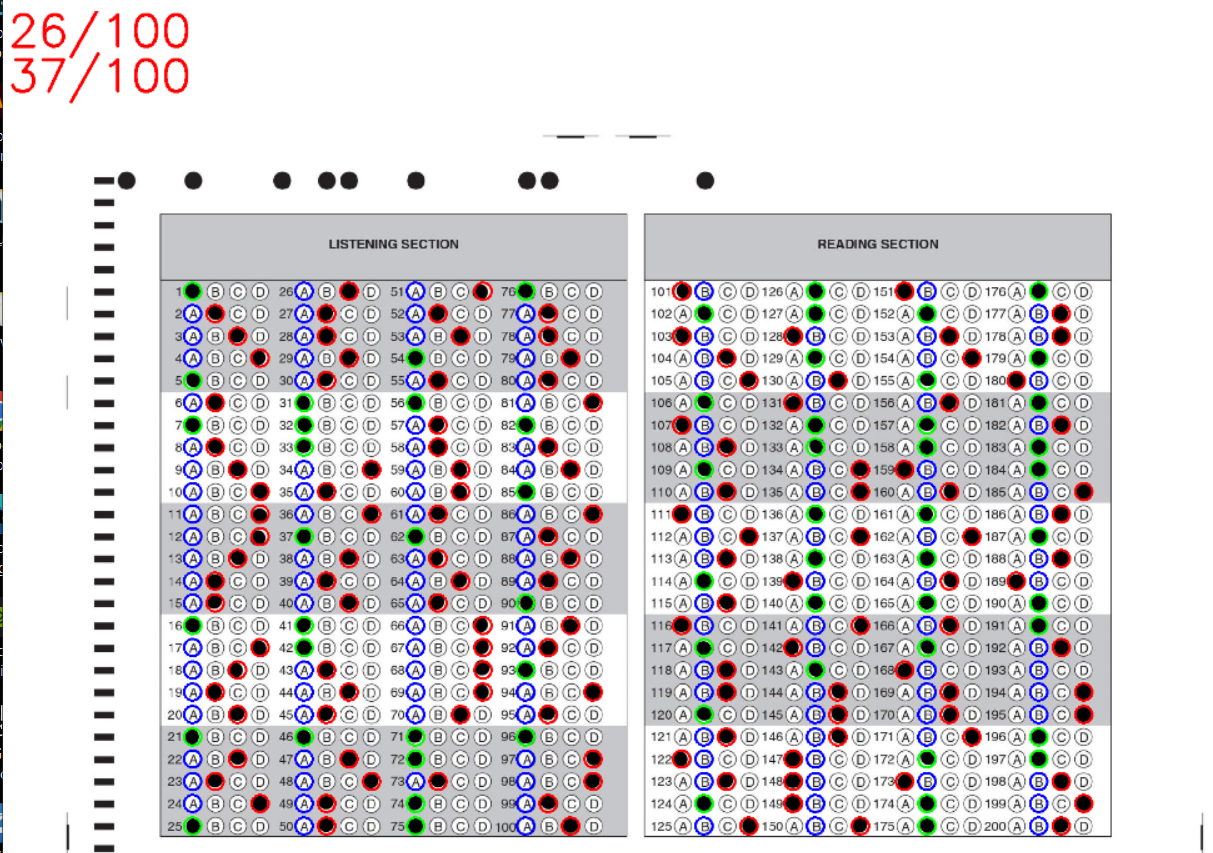

# Result img1

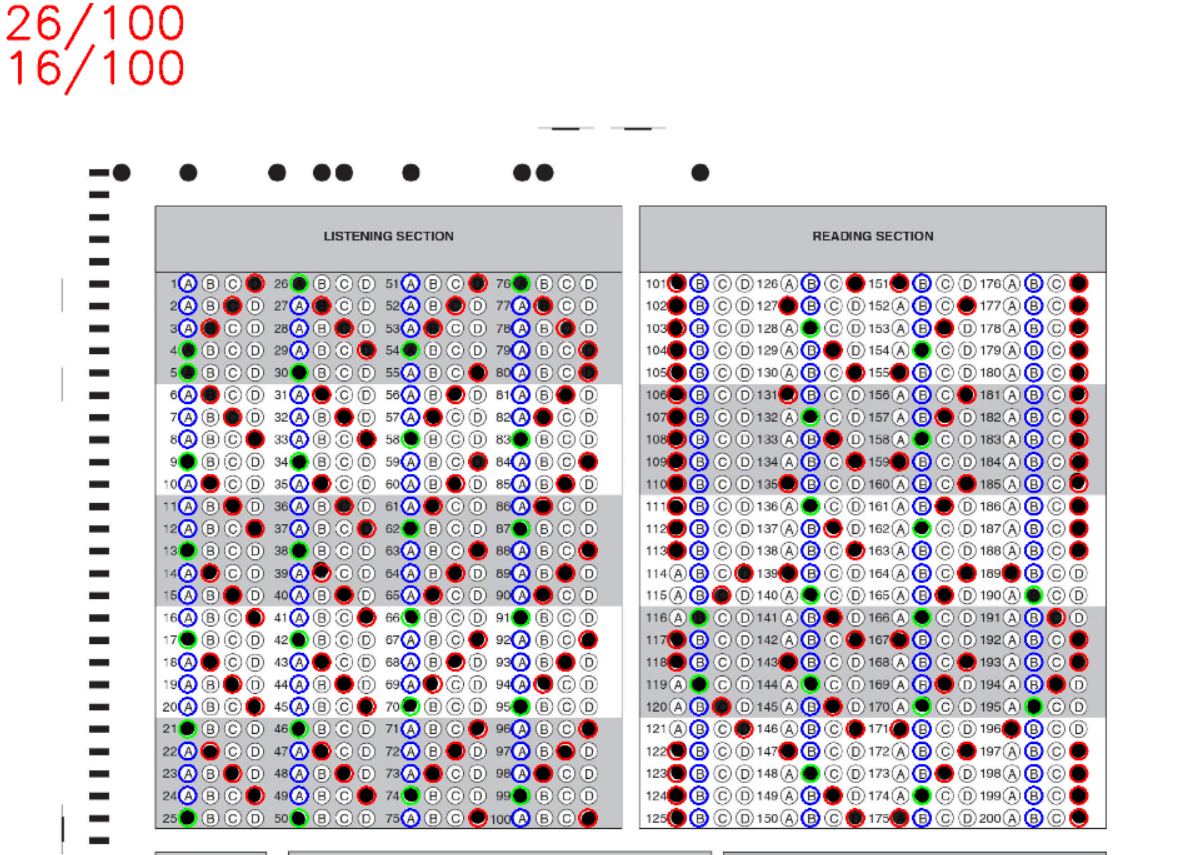